# only compare online or pseudo-online performance

In [4]:
%reload_ext autoreload
%autoreload 2
import pickle
import pandas as pd 
from pyneurode.spike_sorter import *
import sys
sys.path.append('..\\..\\spikeforest_comparison')

from ShadowExtractor import  ShadowSortingExtractor
import spikeinterface as si
import spikeinterface.comparison as sc
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.toolkit as st
import spikeinterface.widgets as sw
from spikeforest2 import processing, sorters
from spikeforest2_utils import (AutoRecordingExtractor, AutoSortingExtractor,
                                MdaRecordingExtractor)
import file_utility
from tqdm import tqdm
from analysis_utils import *
import seaborn as sns 

### Loading previously detected spikes

In [7]:
# load previous collected spikes
print('Loading spike data')
# path = 'D:\Documents\GitHub\spikeforest_comparison\data\df_sort_M1_D20_45_th5.pkl'
path = '..\data\df_sort_M1_D20_45_th5.pkl'
with open(path,'rb') as f:
    df_list = pickle.load(f)

df = pd.concat(df_list)   
df.reset_index() #make sure no index has duplicates

# Save the online cluster id to another column
df.rename(columns={'cluster_id':'cluster_id_online'},inplace=True)
df

Loading spike data


,spike_waveform,time,electrode_ids,channel_ids,spike_id,timestamps,acq_timestamps,cluster_id_online,dist_tm,spike_waveform_aligned,spike_time,sort_timestamps
0,"[-0.05250948, -0.14332052, -0.022488609, 0.048...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,375862,1.615648e+09,C1_5,0.799257,"[0.048003923147916794, -0.21444782614707947, -...",12.464733,1.615648e+09
1,"[-0.5246422, -0.609553, -0.35305232, -0.039588...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,376256,1.615648e+09,C1_2,0.567972,"[-0.039588578045368195, -0.12017491459846497, ...",12.477867,1.615648e+09
2,"[-0.45728362, 0.3922822, 0.60337937, 0.3992793...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,376899,1.615648e+09,C1_3,0.800543,"[0.3992793560028076, -0.10937236249446869, -0....",12.499300,1.615648e+09
3,"[0.46189496, 1.5869086, 1.8508329, 1.4992404, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,377838,1.615648e+09,C2_1,0.908876,"[1.4992403984069824, 1.132098913192749, 0.6527...",12.530600,1.615648e+09
4,"[0.909833, 0.2761541, 0.17282563, 0.516779, 1....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,377887,1.615648e+09,C1_2,0.503494,"[0.5167790055274963, 1.1071397066116333, 1.749...",12.532233,1.615648e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
10,"[0.06949595, 0.29736862, 0.81068987, 1.116027,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,9118576,1.615648e+09,C0_3,0.532886,"[1.1160269975662231, 0.888058602809906, 0.3635...",303.888533,1.615648e+09
11,"[0.16372728, -0.009656481, 0.16306406, -0.3709...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11,9118598,1.615648e+09,C2_2,0.467057,"[-0.3709728717803955, -1.4567493200302124, -1....",303.889267,1.615648e+09
12,"[-0.8042053, -0.5876875, 0.13034075, 0.6422738...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12,9118667,1.615648e+09,C1_5,0.761249,"[0.6422738432884216, 0.7085359692573547, 0.359...",303.891567,1.615648e+09
13,"[-0.020245934, 1.4837929, 1.8430108, 1.3749459...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,9118788,1.615648e+09,C3_1,1.025305,"[1.374945878982544, 0.7906058430671692, 0.8324...",303.895600,1.615648e+09


### Clusting-TM split

In [9]:

# %% Sorting spikes
print('Sorting spikes')
training_spikes = 20000
df_sort = df.loc[:, ['spike_waveform','time','electrode_ids','channel_ids','spike_id','timestamps','acq_timestamps']] # remove other columns

# train template
df_train,pca_transformer,_ = sort_all_electrodes(df_sort.iloc[:training_spikes].copy(), pca_component=3, verbose=True) #sort spikes

(templates, template_cluster_id, template_electrode_id) = generate_spike_templates(df_train)
print(f'Number of template {len(templates)}')

# template match all subsequent neurons
df_matched = template_match_all_electrodes(df_sort.copy(), templates, template_electrode_id, template_cluster_id)

Sorting spikes
Aligning spikes
Sorting electrode 1
use normalized pc
Sorting electrode 2
use normalized pc
Sorting electrode 0
use normalized pc
Sorting electrode 3
use normalized pc
Number of template 14


### Make extractor

In [10]:
#%% Make extractor
sorter_online = make_extractor(df_matched)

['C1_5' 'C1_2' 'C1_3' 'C2_1' 'C1_4' 'C0_1' 'C0_2' 'C1_1' 'C3_1' 'C2_2'
 'C2_3' 'C0_3' 'C3_2' 'C1_6']


### Compare sorters

Comparing sorters


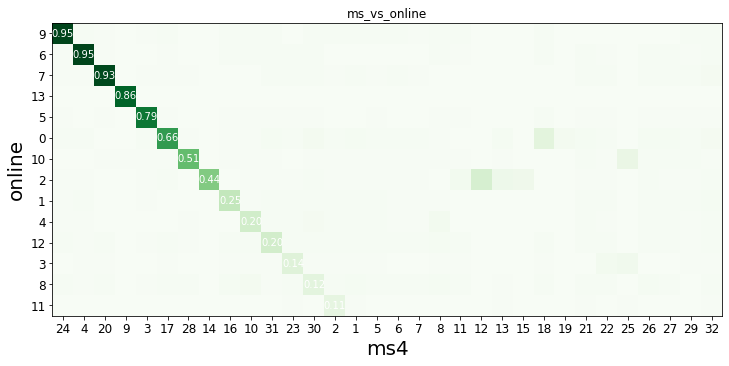

In [12]:
print('Comparing sorters')
# compare results with mountainsort
#load previous results
with open('../../spikeforest_comparison/sorter_results.pkl','rb') as f:
    sorter_result = pickle.load(f)

compare_sorters(sorter_online,sorter_result)

In [ ]:
0.4e-3*30000

12.0

In [13]:
with open('../../spikeforest_comparison/sorter_results.pkl','rb') as f:
    sorter_result = pickle.load(f)

['C1_1' 'C1_2' 'C1_3' 'C2_1' 'C1_4' 'C1_5' 'C0_1' 'C0_2' 'C3_1' 'C2_2'
 'C2_3' 'C0_3' 'C3_2' 'C1_6']


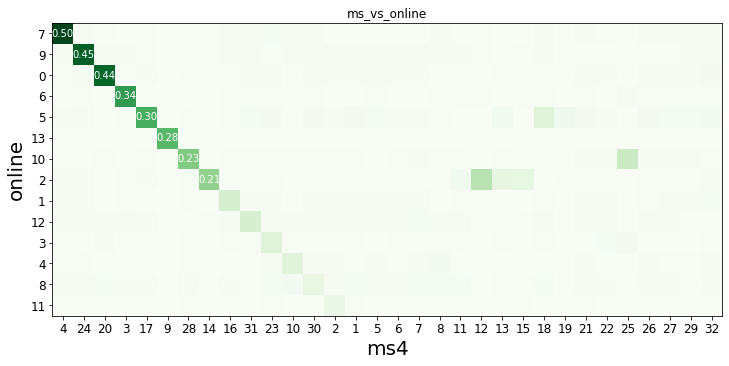

In [14]:
# results based on clustering and PCA from the initial template calculation
sorter_online_template = make_extractor(df_train)
comparison = compare_sorters(sorter_online_template,sorter_result)

['C1_5' 'C1_2' 'C1_3' 'C2_1' 'C1_4' 'C0_1' 'C0_2' 'C1_1' 'C3_1' 'C2_2'
 'C2_3' 'C0_3']


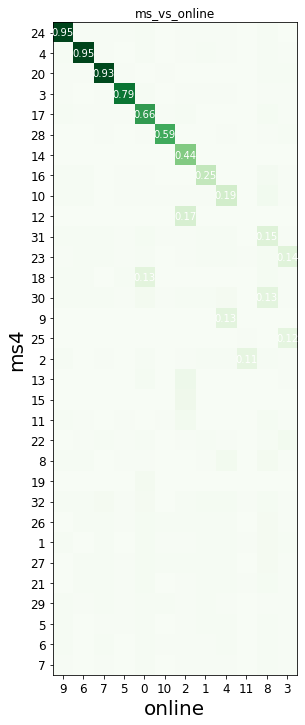

In [15]:
sorter_online_realtime = make_extractor(df,'cluster_id_online')
comparison = compare_sorters(sorter_online_realtime,sorter_result, yaxis='ms4')

### Compare the average offline agreement and online

In [16]:
# get the average agreement score
#remove the online
Fs = 30000
sorter_result['online']= sorter_online_realtime #Add the online results to comparison

sorter_list = list(sorter_result.keys())
mcmp = sc.compare_multiple_sorters(sorting_list=list(sorter_result.values()),
                                   name_list=sorter_list, verbose=True, sampling_frequency=Fs)
sorter_agreement={}

for c in mcmp.comparisons:
    if 'mountainsort' in c.name_list:
        ms_idx = c.name_list.index('mountainsort')
        if ms_idx ==0:
            # ms result should in rows
            agreement_score = c.agreement_scores
        else:
            agreement_score = c.agreement_scores.T

        sorter_agreement[c.name_list[1-ms_idx]] = agreement_score.max(axis=1) #store the max agreement

Multicomaprison step 1: pairwise comparison
  Comparing:  herding  and  mountainsort
  Comparing:  herding  and  klusta
  Comparing:  herding  and  ironclust
  Comparing:  herding  and  spyking
  Comparing:  herding  and  online
  Comparing:  mountainsort  and  klusta
  Comparing:  mountainsort  and  ironclust
  Comparing:  mountainsort  and  spyking
  Comparing:  mountainsort  and  online
  Comparing:  klusta  and  ironclust
  Comparing:  klusta  and  spyking
  Comparing:  klusta  and  online
  Comparing:  ironclust  and  spyking
  Comparing:  ironclust  and  online
  Comparing:  spyking  and  online
Multicomaprison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomaprison step 4: extract agreement from graph


In [17]:
df_agree = pd.DataFrame(sorter_agreement)
df_agree['cluster_id'] = df_agree.index
df_agree = df_agree.melt(id_vars='cluster_id',var_name='method',value_name='agreement')
df_agree['type'] = 'offline'
df_agree.loc[df_agree.method=='online','type'] = 'online'
df_agree

,cluster_id,method,agreement,type
0,1,herding,0.010137,offline
1,2,herding,0.084620,offline
2,3,herding,0.764684,offline
3,4,herding,0.988977,offline
4,5,herding,0.051604,offline
...,...,...,...,...
155,28,online,0.591349,online
156,29,online,0.010674,online
157,30,online,0.119290,online
158,31,online,0.140109,online


### Agreement orded by offline average 

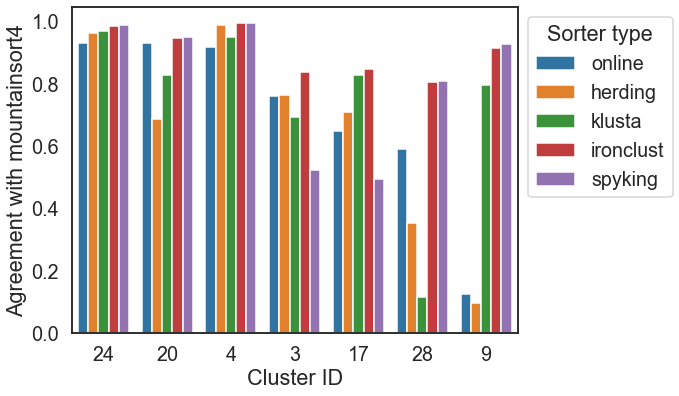

In [60]:
sns.set_style('white')
sns.set_context("talk",font_scale=1.2)
offline_agreement = df_agree[df_agree.type=='offline'].groupby(['cluster_id']).mean().sort_values('agreement',ascending=False)
order = offline_agreement.index
cluster_sel = order[offline_agreement.agreement>0.5] #only plot cells with >0.5 agreement
df_agree2plot = df_agree[df_agree.cluster_id.isin(cluster_sel)]

online_clusters = df_agree[df_agree.type=='online'].sort_values('agreement', ascending=False).cluster_id
cluster_order = online_clusters[online_clusters.isin(cluster_sel)]

fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.barplot(x='cluster_id', y='agreement',hue='method',data=df_agree2plot, order=cluster_order, hue_order=['online','herding','klusta','ironclust','spyking'], ax=ax)
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Agreement with mountainsort4')
ax.legend(title='Sorter type',bbox_to_anchor=(1,1))
# plt.savefig('figures/offline_vs_realtime_method.png',bbox_inches='tight', dpi=300)

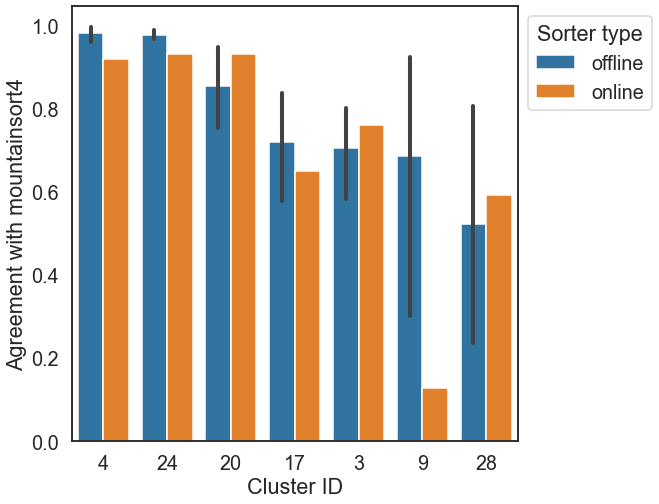

In [62]:
# sns.set_context('talk')
sns.set_style('white')
sns.set_context("talk",font_scale=1.2)

offline_agreement = df_agree[df_agree.type=='offline'].groupby(['cluster_id']).mean().sort_values('agreement',ascending=False)
order = offline_agreement.index
cluster_sel = order[offline_agreement.agreement>0.5] #only plot cells with >0.5 agreement
df_agree2plot = df_agree[df_agree.cluster_id.isin(cluster_sel)]

fig,ax = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='cluster_id', y='agreement',hue='type',data=df_agree2plot,order = cluster_sel, ax=ax)
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Agreement with mountainsort4')
ax.legend(title='Sorter type',bbox_to_anchor=(1,1))
plt.savefig('figures/offline_vs_realtime.png',bbox_inches='tight',dpi=300)

### Agreement ordered by online

<AxesSubplot:xlabel='cluster_id', ylabel='agreement'>

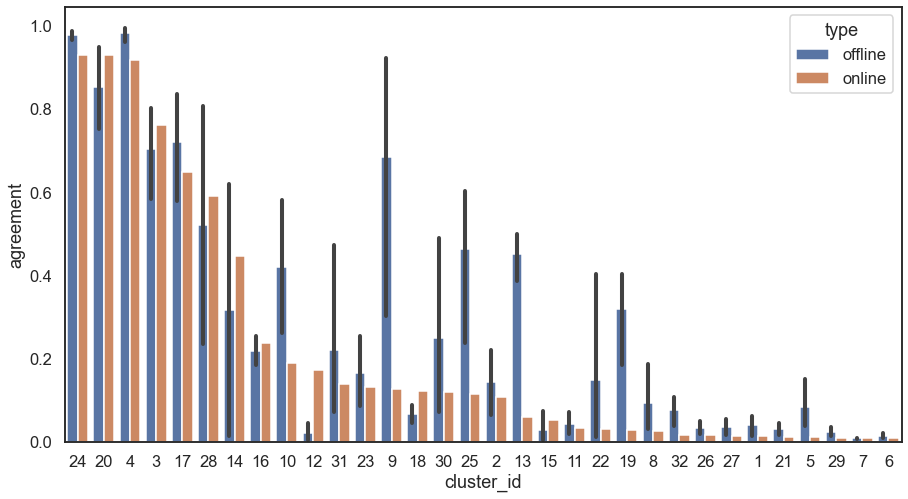

In [40]:
sns.set_theme(font_scale=1.2)
sns.set_style('white')
sns.set_context("talk")
order = df_agree[df_agree.type=='online'].sort_values('agreement', ascending=False).cluster_id
fig,ax = plt.subplots(1,1,figsize=(15,8))
sns.barplot(x='cluster_id', y='agreement',hue='type',data=df_agree,order = order, ax=ax)